<a href="https://colab.research.google.com/github/DavidEmeryUofC/CDS_Project_Restaurant_Rev_Prediction/blob/main/CDSproject2_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

<center> <h1> <span style='color:#292D78'> CREWES Data Science Training </span> </h1> </center>

<center> <h2> <span style='color:#DF7F00'> Project: Restaurant Revenue Prediction </span> </h2> </center>

---

This [Jupyter Notebook](https://jupyter.org/install) is for analysing the data in the [Kaggle Project](https://www.kaggle.com/competitions/restaurant-revenue-prediction/discussion) for estimation of Restaurant [Revenue](https://www.kaggle.com/competitions/restaurant-revenue-prediction).  

Project members are: [David Emery](https://www.linkedin.com/in/david-emery-54659a3a/), [Nazhat Shirin Rashid](https://www.linkedin.com/in/nazhatrashid/), [Stephanie Misailidis](https://www.linkedin.com/in/stephanie-jimenez-misailidis-54a6b3b1/?originalSubdomain=ca), and [Reginaldo Moriera](https://www.linkedin.com/in/reginaldo-moreira-70a016b3/)

### Data fields
Id : Restaurant id.   
Open Date : opening date for a restaurant  
City : City that the restaurant is in. Note that there are unicode in the names.   
City Group: Type of the city. Big cities, or Other.   
Type: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile  
P1, P2 - P37: There are three categories of these obfuscated data.   
- Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales.  
- Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability.  
- Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.  

Revenue: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. 

In [ ]:
# Core utilities
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (10,7)}) # default figure size set for Powerpoint

# print plots
%matplotlib inline 

# To supress warnings and deprecated messages
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Data pre-processing
from sklearn.preprocessing import StandardScaler

# Cluster Analysis
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture

# Dimensionality reduction
from sklearn.decomposition import PCA

# To visualize the elbow curve
from yellowbrick.cluster import kelbow_visualizer

# To perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# To compute distances
from scipy.spatial.distance import pdist

## Import data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


In [ ]:
filepath = '/content/drive/MyDrive/CDS_Course/project'
filename = filepath + '/test.csv'
print(filename)
df_test = pd.read_csv(filename)
df_test.head()

In [ ]:
df_test.shape

In [ ]:
filename = filepath + '/train.csv'
print(filename)
df_train = pd.read_csv(filename)
df_train.head()

In [ ]:
df_train.shape

The training set only contains 137 restaurant with revenue while the test data contain 100000 restaurant.

### Convert the open date to the number of days open


In [ ]:
df_train["ODate"] = pd.to_datetime(df_train["Open Date"], format = "%m/%d/%Y", utc = False)
df_test["ODate"] = pd.to_datetime(df_test["Open Date"], format = "%m/%d/%Y", utc = False)

firstopenT = pd.to_datetime(df_test["ODate"].min(), format='%Y-%m-%d', utc = False)
lastopenT = pd.to_datetime(df_test["ODate"].max(), format='%Y-%m-%d', utc = False)
print("test data",firstopenT,lastopenT)

firstopen = pd.to_datetime(df_train["ODate"].min(), format='%Y-%m-%d', utc = False)
lastopen = pd.to_datetime(df_train["ODate"].max(), format='%Y-%m-%d', utc = False)
print("train data",firstopen,lastopen)

df_train["DOpen"] = (lastopen - df_train["ODate"])/ pd.offsets.Day(1) + 365*2 
df_test["DOpen"] = (lastopen - df_test["ODate"])/ pd.offsets.Day(1) + 365*2 

The train data set spans from the start of 1996 to the end of 2014 (18 years). The test dataset spans 19 years and as the contest was 7 years ago might be safe to assume a minimum of 2 year open. As the training data has the newest day it will be used to determine the number of days the restaurants has been open.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.histplot(data=df_train, x="revenue", hue="Type", multiple="stack", kde=True, ax = ax[0]).set(title='Histogram of Revenue');
g2 = sns.scatterplot(data=df_train,x="DOpen",y="revenue", hue="Type", ax = ax[1]).set(title='Revenue by Days since opening');
fig.show();

Revenue per day assuming at least 2 years of revenue

In [ ]:
from sklearn.linear_model import LinearRegression

# Creating the model
model_lr = LinearRegression()

# Linear model on the train data
features = ['DOpen']
model_lr.fit(df_train[features], df_train['revenue'])
DOpenInt = model_lr.intercept_
DOpen1 = model_lr.coef_
print('Intercept is ', DOpenInt,' +', DOpen1[0],' days open')

In [ ]:
df_train['RevC'] = df_train['revenue'] - (DOpenInt + (DOpen1[0] * (df_train['DOpen'])))

fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.histplot(x=(df_train['RevC']),hue=df_train["Type"], kde=True, ax=ax[0]);
g2 = sns.scatterplot(data=df_train,x="DOpen",y="RevC", hue="Type", ax=ax[1]);
plt.suptitle('Revenue corrected for time',fontsize=14)
fig.show();

Create 2 category field: one for City Group (1 Big/0 other) and Type ('IL' 1 remainer 0 'FC','DT','MB')

In [ ]:
# Encoding Categorical Variable for City Group and Type
cat_vars = ['City Group', 'Type']
df_train['City_Group'] = 0
df_test['City_Group'] = 0
df_train['TypeC'] = 0
df_test['TypeC'] = 0
df_train['City_Group'][df_train['City Group'] =='Big Cities'] = 1
df_test['City_Group'][df_test['City Group'] == 'Big Cities'] = 1
df_train['TypeC'][df_train['Type'] == 'IL'] = 1
df_test['TypeC'][df_test['Type'] == 'IL'] = 1

### Basic correlation analysis:

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(19, 7))
g1 = sns.heatmap(data = df_train.corr(method = "spearman"), vmin = -1, vmax = 1, annot = False, cmap ='bwr', ax=ax[0]).set(title='Training Data');
g2 = sns.heatmap(data = df_test.corr(method = "spearman"), vmin = -1, vmax = 1, annot = False, cmap ='bwr', ax=ax[1]).set(title='Testing Data');
fig.show()

In [ ]:
df_train.columns

In [ ]:
# Extracting names of numerical and categorical features
cols_num = list(df_train.drop(columns = ["Id","revenue",'RevC']).select_dtypes(include = ["int64", "float64"]))
cols_cat = list(df_train.drop(columns = ["Id","revenue",'RevC']).select_dtypes(include = ["object", "category", "bool"]))

print("Numerical columns:", cols_num)
print("Categorical columns:", cols_cat)

2/3 of P14-P18, P24-P27 and P30-37 are zeros, replace with nan's, standard scale and then replace nan's with zero.  To make sure that both the training and test data sets are scale equivalent merge for scaling then again seperate out the training set.

In [ ]:
df_merged = pd.concat([df_test, df_train], axis=0, ignore_index=True).copy()

In [ ]:
df_merged.shape

In [ ]:
columnZeros = ['P14','P15','P16','P17','P18','P24','P25','P26','P27','P30','P31','P32','P33','P34','P35','P36','P37']
for i in columnZeros:
  df_merged[i][df_merged[i] == 0] = np.nan

In [ ]:
cols_scale = list(df_train.drop(columns = ["Id",'DOpen','revenue','RevC','City_Group','TypeC']).select_dtypes(include = ["int64", "float64","int8"]))

In [ ]:
df_merged.head()

In [21]:
from sklearn.preprocessing import StandardScaler
# Z-score
scaler = StandardScaler()
df_merged[cols_scale] = scaler.fit_transform(df_merged[cols_scale])
df_merged.describe().T

count          mean           std           min           25%  \
Id          100137.0  4.993119e+04  2.890688e+04  0.000000e+00  2.489700e+04   
P1          100137.0  6.506763e-17  1.000005e+00 -1.097708e+00 -7.422244e-01   
P2          100137.0  1.915841e-16  1.000005e+00 -2.398969e+00 -2.995571e-01   
P3          100137.0  7.840755e-17  1.000005e+00 -5.003827e+00 -2.557603e-01   
P4          100137.0  2.860989e-16  1.000005e+00 -2.313201e+00 -3.823093e-01   
P5          100137.0 -7.862043e-17  1.000005e+00 -9.287684e-01 -9.287684e-01   
P6          100137.0  5.279205e-17  1.000005e+00 -1.228423e+00 -5.758917e-01   
P7          100137.0 -9.494055e-17  1.000005e+00 -1.973940e+00 -1.380062e-01   
P8          100137.0  1.941740e-16  1.000005e+00 -2.287383e+00 -5.418684e-01   
P9          100137.0  1.870251e-16  1.000005e+00 -7.350439e-01 -7.350439e-01   
P10         100137.0  1.810824e-16  1.000005e+00 -8.272444e-01 -2.602546e-01   
P11         100137.0  9.352141e-17  1.000005e+00 -1.117879e+00 -6.342945e-01   
P12         100137.0 -1.119702e-16  1.000005e+00 -1.734084e+00 -6.013493e-01   
P13         100137.0  3.198744e-16  1.000005e+00 -2.130490e+00 -8.844243e-02   
P14          34315.0 -1.035324e-16  1.000015e+00 -9.109487e-01 -5.780072e-01   
P15          34277.0 -2.135131e-17  1.000015e+00 -1.380977e+00 -8.902781e-01   
P16          33955.0  9.170825e-17  1.000015e+00 -1.192387e+00 -6.181694e-01   
P17          34257.0  2.914186e-17  1.000015e+00 -7.618384e-01 -7.618384e-01   
P18          34069.0  1.179406e-16  1.000015e+00 -1.249906e+00 -6.284554e-01   
P19         100137.0  3.682672e-17  1.000005e+00 -7.243830e-01 -5.515293e-01   
P20         100137.0 -6.274378e-17  1.000005e+00 -9.884575e-01 -7.116429e-01   
P21         100137.0 -1.234653e-17  1.000005e+00 -6.105853e-01 -6.105853e-01   
P22         100137.0  1.827854e-16  1.000005e+00 -1.049214e+00 -1.049214e+00   
P23         100137.0  1.901649e-17  1.000005e+00 -5.593846e-01 -5.593846e-01   
P24          34283.0  9.129717e-17  1.000015e+00 -1.256730e+00 -7.745311e-01   
P25          34311.0 -4.141778e-18  1.000015e+00 -1.312321e+00 -8.134951e-01   
P26          34265.0 -3.608184e-17  1.000015e+00 -1.083993e+00 -6.884465e-01   
P27          33855.0 -4.648803e-17  1.000015e+00 -9.818712e-01 -5.801448e-01   
P28         100137.0  4.583826e-17  1.000005e+00 -1.045324e+00 -5.773599e-01   
P29         100137.0 -8.280689e-17  1.000005e+00 -1.728957e+00 -6.077393e-01   
P30          34453.0 -3.547248e-17  1.000015e+00 -9.240653e-01 -5.586519e-01   
P31          34483.0  3.399923e-17  1.000015e+00 -8.947297e-01 -8.947297e-01   
P32          34262.0 -9.425652e-17  1.000015e+00 -9.375780e-01 -5.369082e-01   
P33          34258.0 -1.318086e-16  1.000015e+00 -1.592033e+00 -7.482982e-01   
P34          34217.0  5.214807e-17  1.000015e+00 -8.263475e-01 -5.068382e-01   
P35          34273.0 -1.157874e-16  1.000015e+00 -1.279099e+00 -3.981463e-01   
P36          34387.0  4.483897e-17  1.000015e+00 -1.043212e+00 -6.025259e-01   
P37          34020.0  1.837971e-17  1.000015e+00 -1.103694e+00 -5.122337e-01   
DOpen       100137.0  2.674604e+03  1.749095e+03  7.300000e+02  1.391000e+03   
City_Group  100137.0  4.928248e-01  4.999510e-01  0.000000e+00  0.000000e+00   
TypeC       100137.0  4.045158e-01  4.908005e-01  0.000000e+00  0.000000e+00   
revenue        137.0  4.453533e+06  2.576072e+06  1.149870e+06  2.999068e+06   
RevC           137.0 -1.699494e-11  2.435499e+06 -4.129899e+06 -1.535563e+06   

                     50%           75%           max  
Id          4.993100e+04  7.496500e+04  9.999900e+04  
P1         -3.867409e-01 -3.125749e-02  3.879060e+00  
P2          4.002469e-01  4.002469e-01  2.149757e+00  
P3         -2.557603e-01 -2.557603e-01  3.898798e+00  
P4         -3.823093e-01  5.831365e-01  2.996751e+00  
P5          9.747209e-03  9.747209e-03  5.640841e+00  
P6         -5.758917e-01  7.291701e-01  4.644355e+00  
P7         -1.380062e-01 -1.380062e-01  2.156911e+00  

replace the nan with zero

In [22]:
df_merged[columnZeros] = df_merged[columnZeros].fillna(0)

## [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) Cluster analysis

In [23]:
model_kmeans_1 = KMeans(n_clusters = 5, random_state = 10).fit(df_merged[cols_scale])
df_merged["kmean5"] = pd.Categorical(model_kmeans_1.labels_)

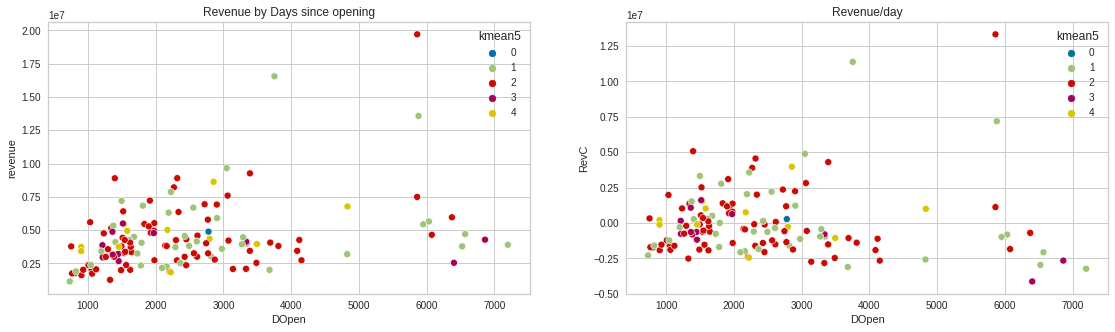

In [24]:
fig, ax = plt.subplots(1,2, figsize=(19,5) )
g1 = sns.scatterplot(data=df_merged[df_merged['revenue'] > 0],x="DOpen",y="revenue", hue="kmean5", ax = ax[0]).set(title='Revenue by Days since opening');
g2 = sns.scatterplot(data=df_merged[df_merged['revenue'] > 0],x="DOpen",y="RevC", hue="kmean5", ax = ax[1]).set(title='Revenue/day')
fig.show();

If you leave DOpen in the features clusters are dominated by time trend

K Elbow Visualizer

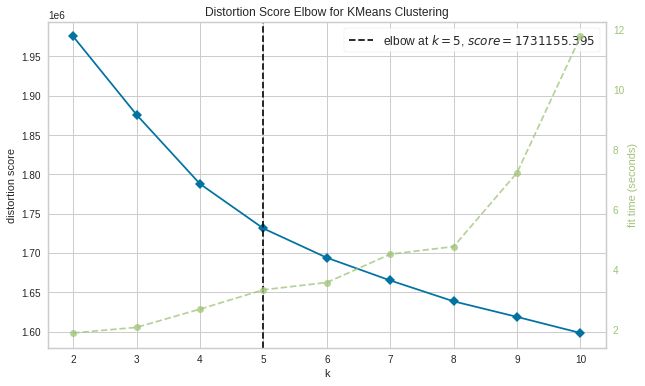

In [25]:
plt.figure(figsize = (10,6))
kelbow_visualizer(model_kmeans_1, X = df_merged[cols_scale], y = df_merged['revenue']);

In [26]:
df_merged['kmean5'].unique()

[2, 1, 0, 4, 3]
Categories (5, int64): [0, 1, 2, 3, 4]

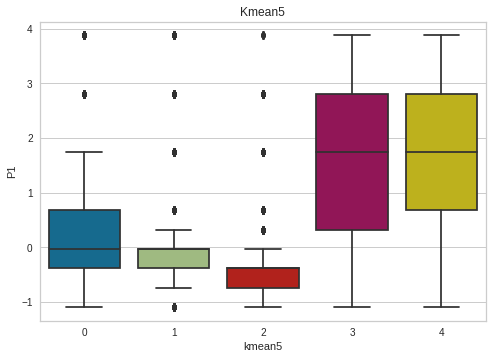

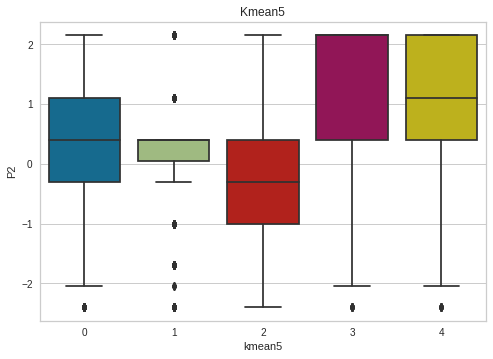

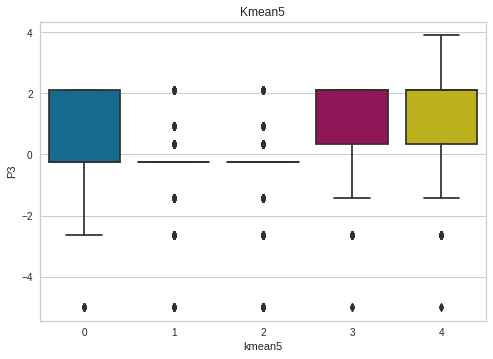

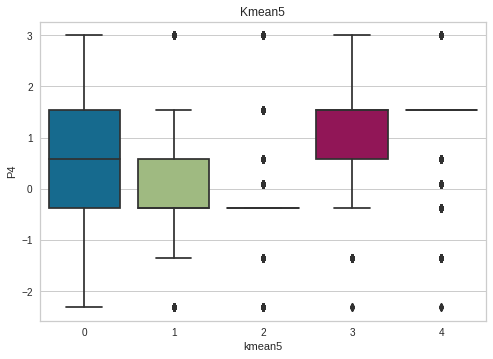

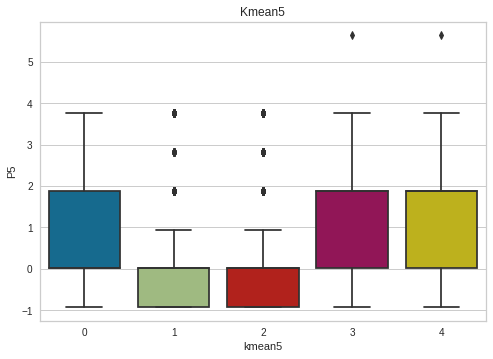

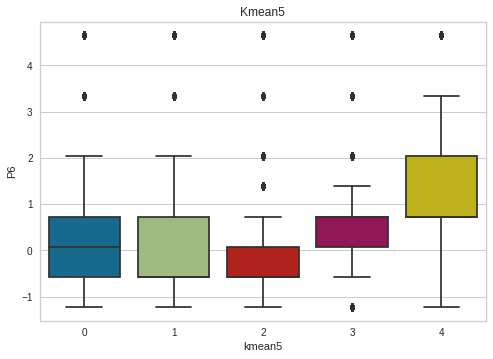

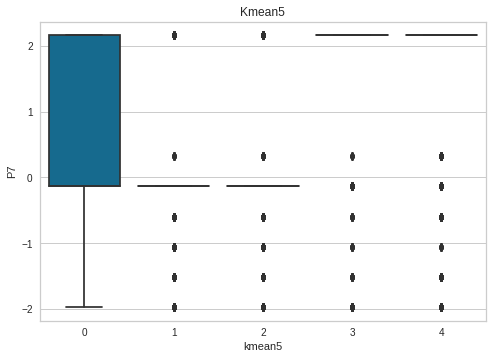

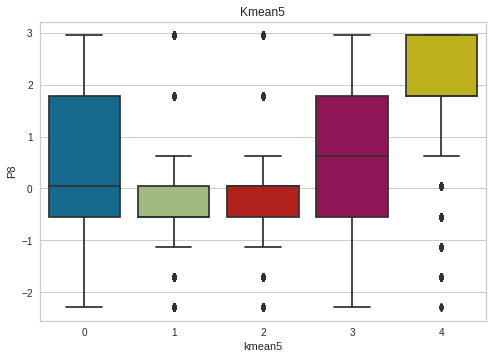

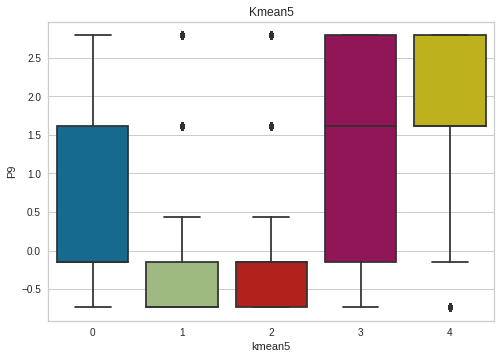

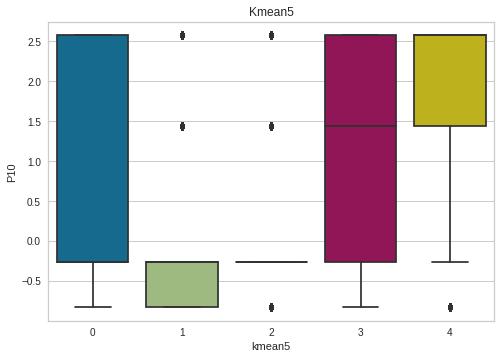

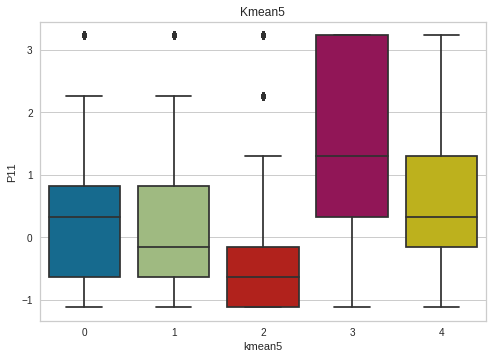

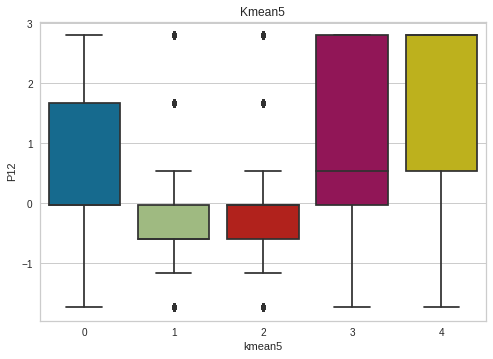

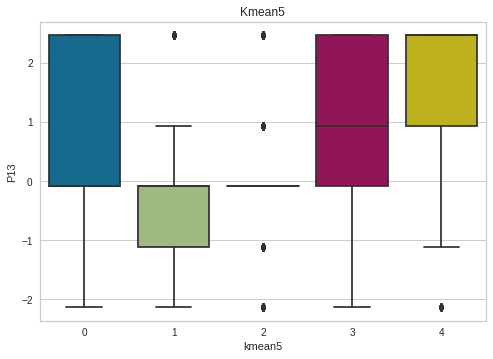

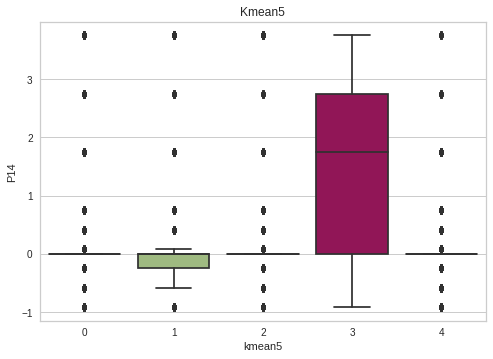

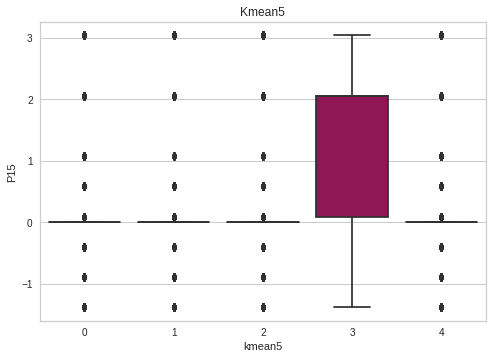

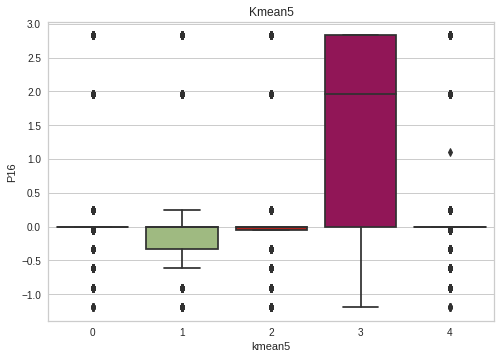

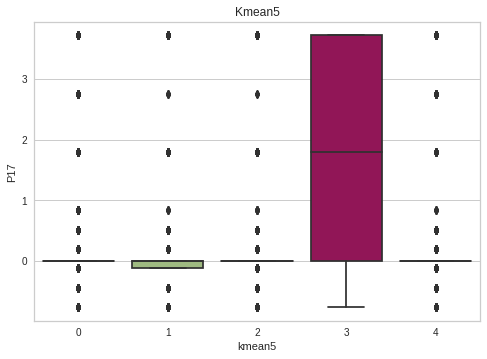

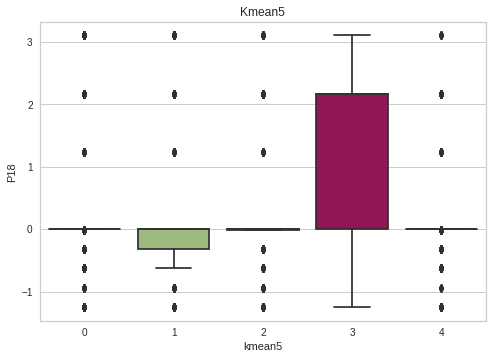

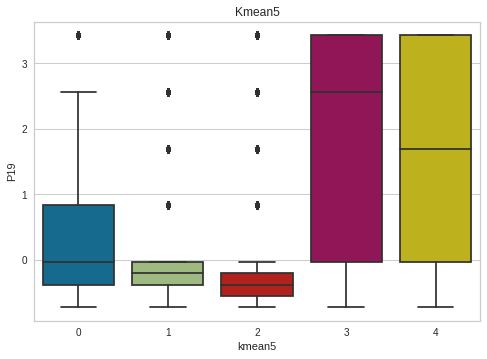

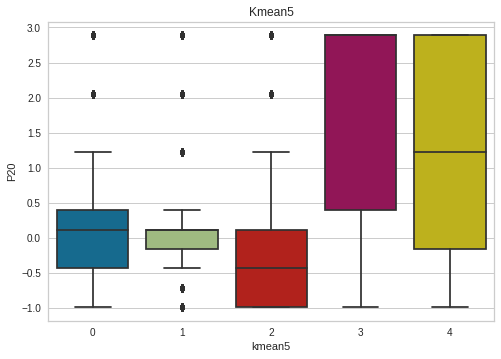

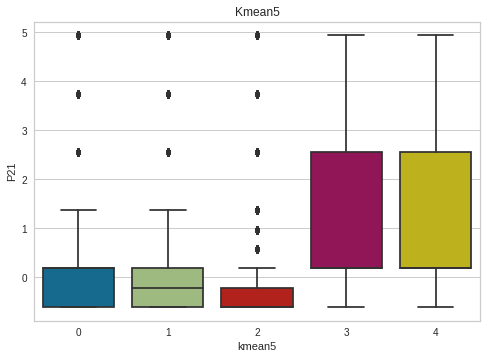

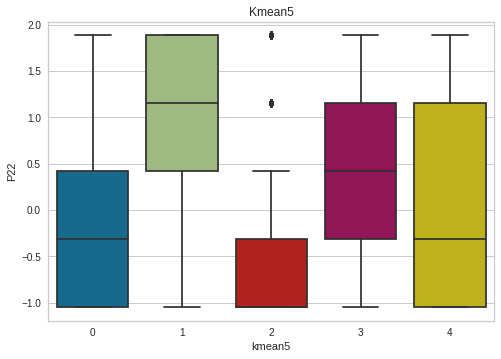

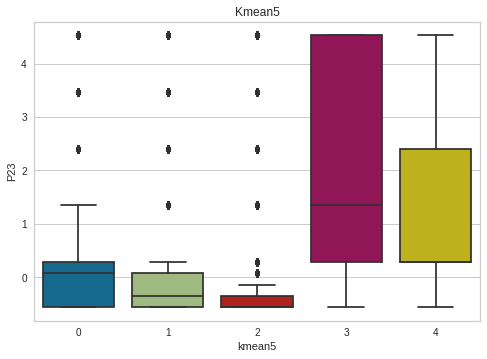

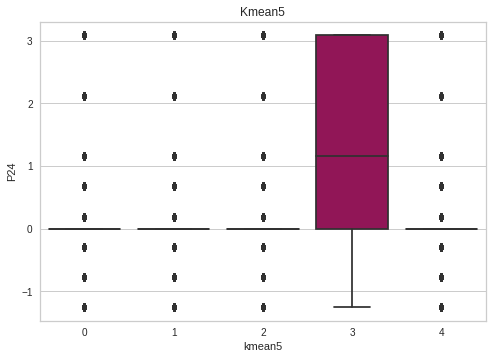

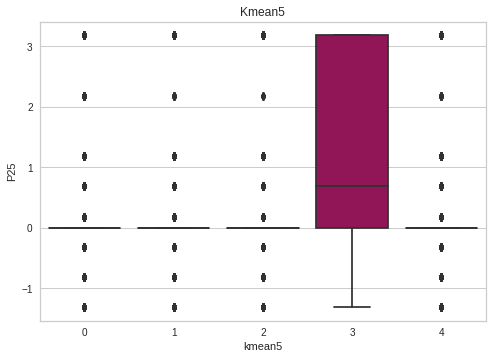

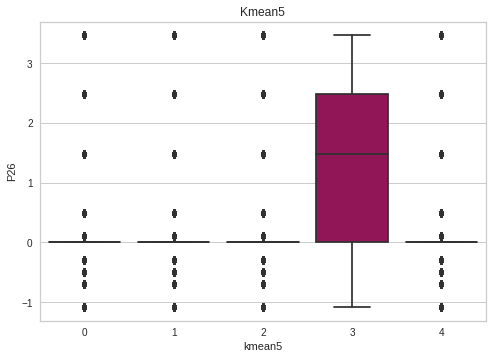

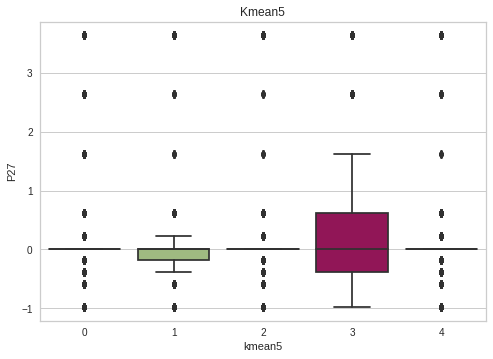

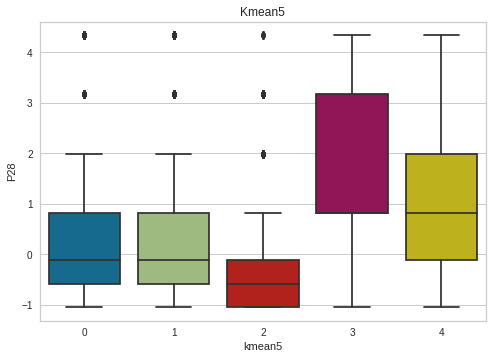

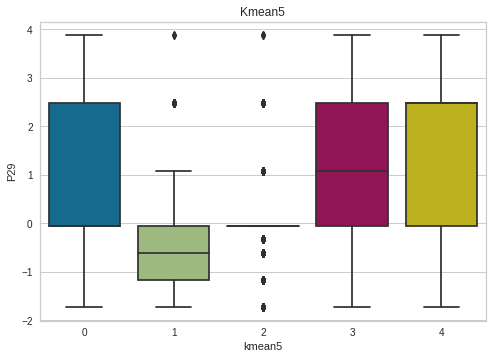

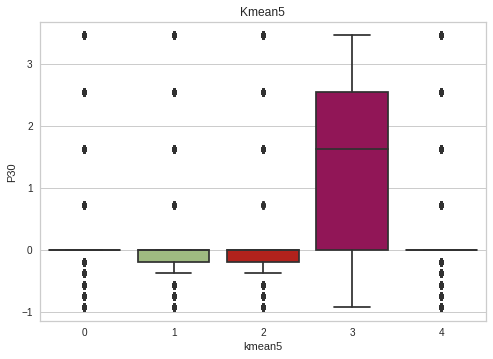

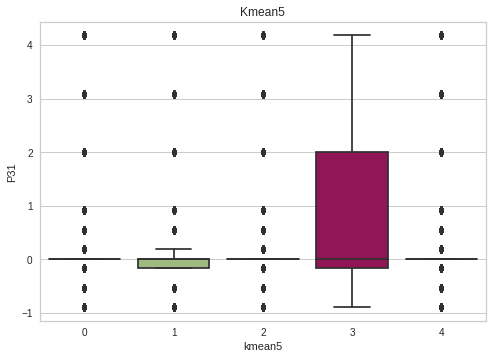

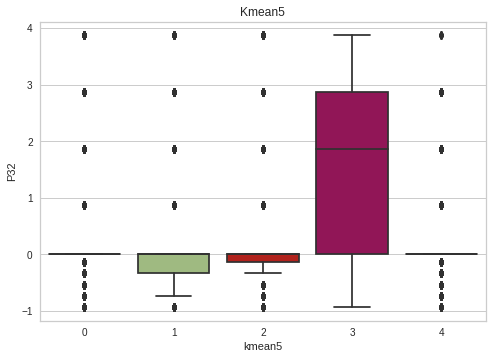

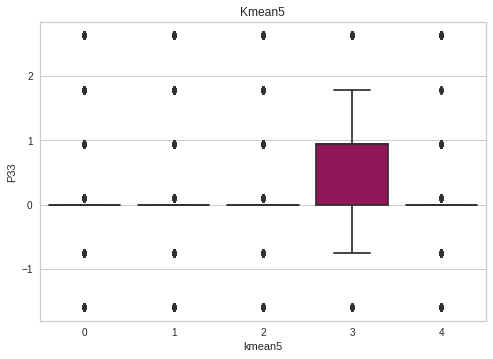

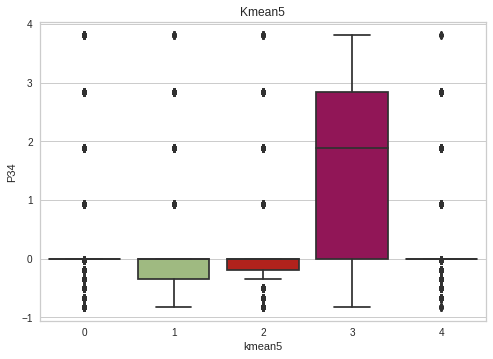

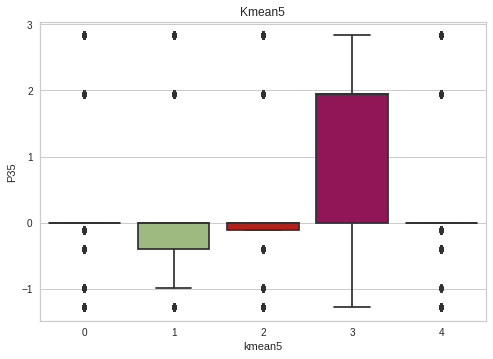

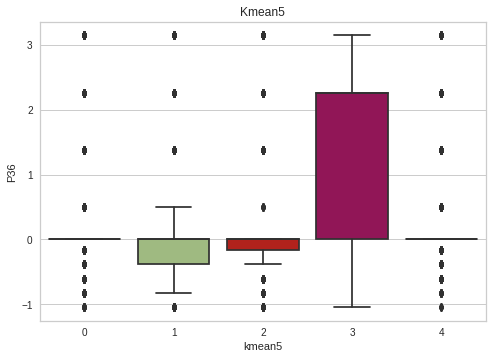

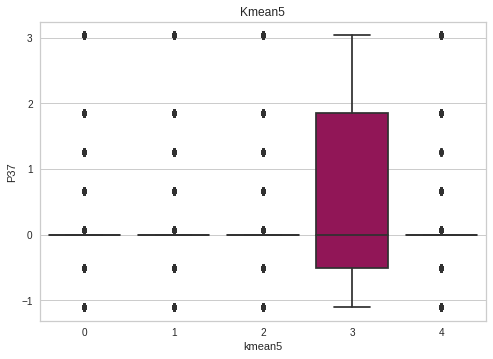

In [27]:
orderKM = [0, 1, 2, 3, 4]
for i in cols_scale:
    sns.boxplot(data = df_merged, x = "kmean5", y = i, order = orderKM, showfliers = True).set(title = 'Kmean5')
    plt.show()

In [28]:
cluster_profile = df_merged.groupby("kmean5").mean()

cluster_profile.style.highlight_max(color="lightgreen", axis=0)

Split back into training and testing datasets

In [29]:
df_training = df_merged[df_merged['revenue'].notna()]
df_testing = df_merged[df_merged['revenue'].isna()]

In [30]:
len(df_training)

137

In [31]:
from sklearn.model_selection import train_test_split
X = df_merged[cols_scale]
y = df_merged['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=12)

In [32]:
# Distance metrics
distances = ["euclidean", "chebyshev", "mahalanobis"]

# Linkage methods
linkages = ["single", "complete", "average"]

# Data Frame for the correlations
coph = pd.DataFrame(columns = ["Distance", "Linkage", "Cophenetic"])

i = 0
# Loop over metrics
for d in distances:

    # Loop over linkages
    for l in linkages:

        # Simple heirarchical clustering
        Z = linkage(X_test[cols_scale], metric = d, method = l)

        # Cophenetic correlation
        c, coph_dists = cophenet(Z, pdist(X_test[cols_scale]))

        coph.loc[i,:] = [d.capitalize(), l.capitalize(), c]

        i = i + 1
        
coph.sort_values("Cophenetic", ascending = False)

Distance   Linkage Cophenetic
2    Euclidean   Average   0.958525
0    Euclidean    Single   0.929932
1    Euclidean  Complete   0.912236
5    Chebyshev   Average   0.891524
3    Chebyshev    Single   0.889895
8  Mahalanobis   Average   0.876229
6  Mahalanobis    Single   0.864885
7  Mahalanobis  Complete   0.776288
4    Chebyshev  Complete   0.751241

In [33]:
# Distance
d = "euclidean"

# Linkage methods
linkages = ["single", "complete", "average", "centroid", "ward", "weighted"]

# Data Frame for the correlations
coph = pd.DataFrame(columns = ["Distance", "Linkage", "Cophenetic"])

i = 0
# Loop over linkages
for l in linkages:

    # Simple heirarchical clustering
    Z = linkage(X_test[cols_scale], metric = d, method = l)

    # Cophenetic correlation
    c, coph_dists = cophenet(Z, pdist(X_test[cols_scale]))

    coph.loc[i,:] = [d.capitalize(), l.capitalize(), c]

    i = i + 1
        
coph.sort_values("Cophenetic", ascending = False)

Distance   Linkage Cophenetic
2  Euclidean   Average   0.958525
3  Euclidean  Centroid   0.934289
0  Euclidean    Single   0.929932
1  Euclidean  Complete   0.912236
5  Euclidean  Weighted   0.904054
4  Euclidean      Ward   0.699471

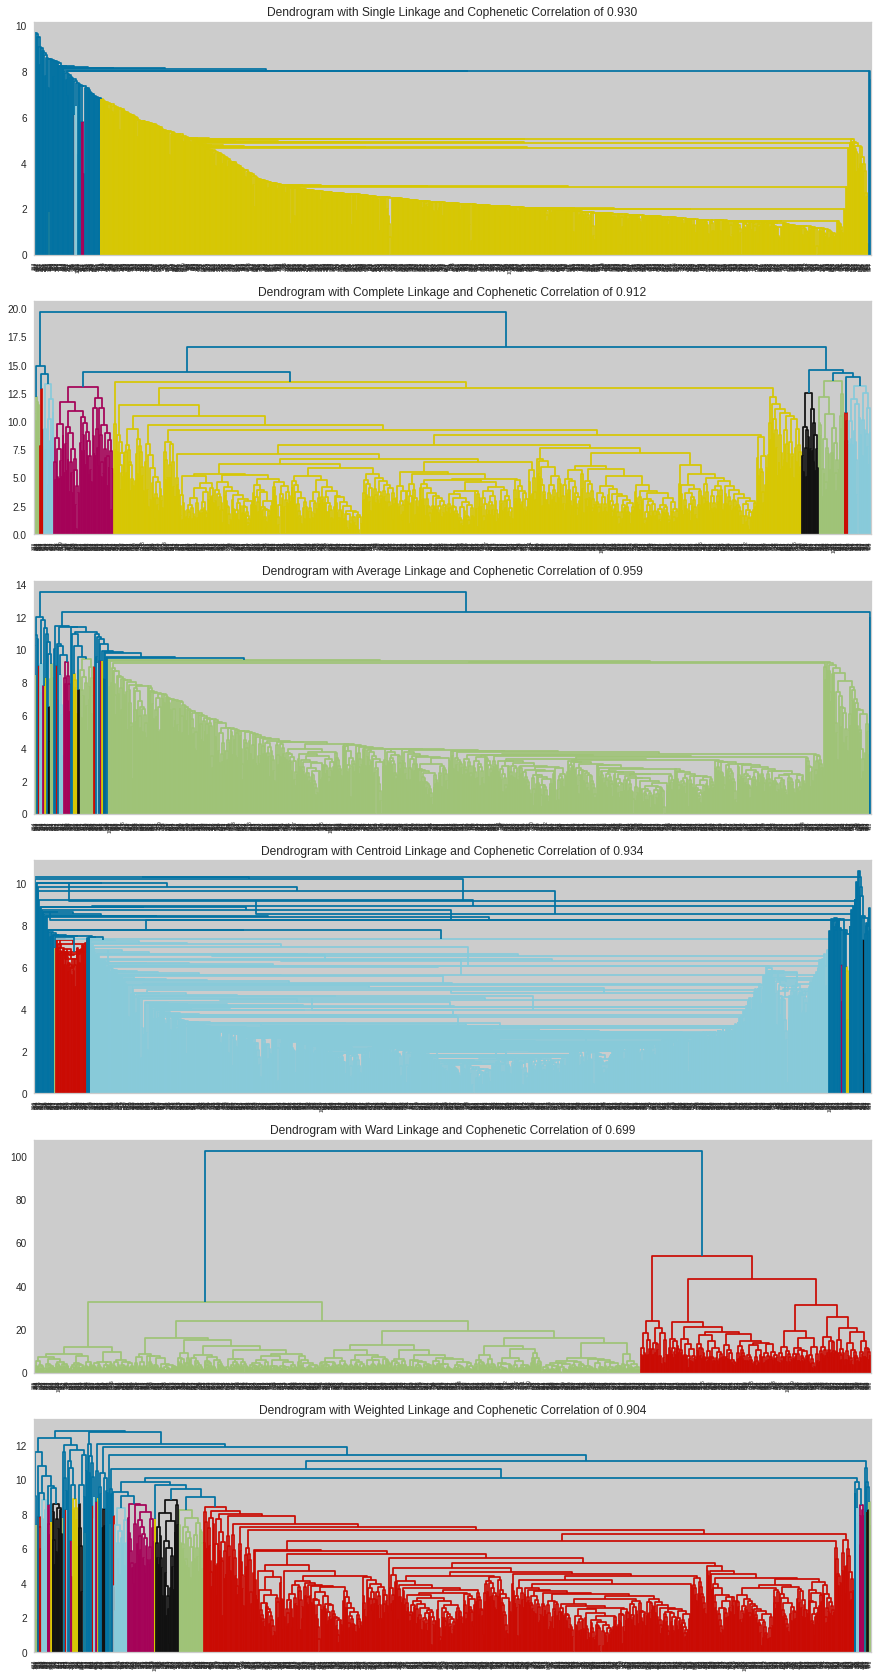

In [34]:
# Figure canvas and subplots
fig, axs = plt.subplots(len(linkages), 1, figsize=(15, 30))

# Loop over linkages
for i, method in enumerate(linkages):

    # Simple hierarchical clustering
    Z = linkage(X_test[cols_scale], metric = "euclidean", method = method)

    # Cophenetic correlation
    c, d = cophenet(Z, pdist(X_test[cols_scale]))

    # Plotting Dendrogram
    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram with {method.capitalize()} Linkage and Cophenetic Correlation of {c:0.3f}")

#[Agglormerative](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

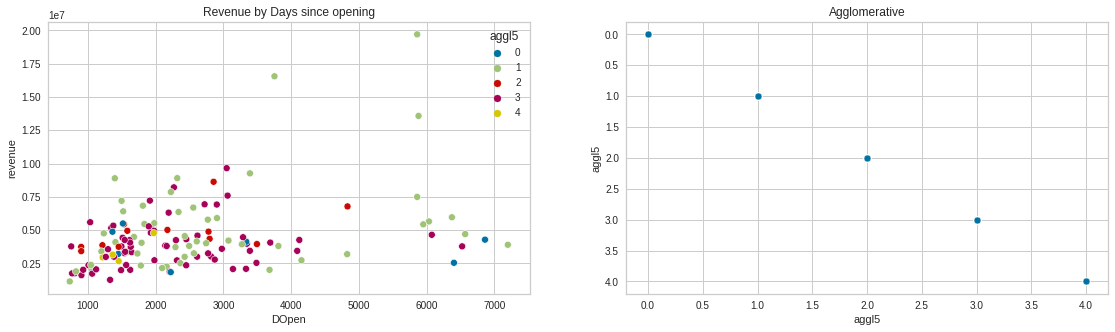

In [35]:
# train model on the smaller subset
model_aggl_1 = AgglomerativeClustering(n_clusters = 5).fit(df_training[cols_scale])
df_training["aggl5"] = pd.Categorical(model_aggl_1.labels_)
fig, ax = plt.subplots(1,2, figsize=(19,5) )
g1 = sns.scatterplot(data=df_training[df_merged['revenue'] > 0],x="DOpen",y="revenue", hue="aggl5", ax = ax[0]).set(title='Revenue by Days since opening');
g2 = sns.scatterplot(data=df_training,x='aggl5',y='aggl5', ax = ax[1]).set(title='Agglomerative')
fig.show();

In [36]:
cluster_profile = df_training.groupby("aggl5").mean()

cluster_profile.style.highlight_max(color="lightgreen", axis=0)

## [DBScan](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) density-based spatial clustering 

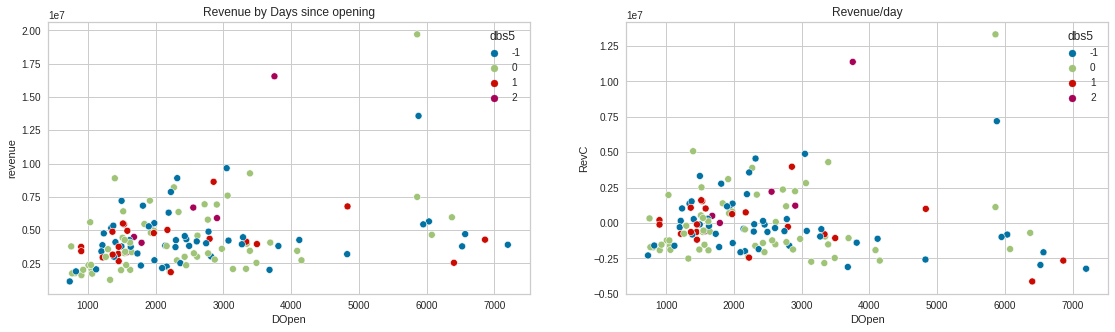

In [37]:
# Training Model
eps = 0.25 # eps greater than 0.4 result in one cluster and less than 0.25 most points fall outside any cluster
model_dbs_1 = DBSCAN(eps = eps, min_samples = 5, metric = "cosine").fit(df_training[cols_scale])
df_training["dbs5"] = pd.Categorical(model_dbs_1.labels_)
fig, ax = plt.subplots(1,2, figsize=(19,5) )
g1 = sns.scatterplot(data=df_training[df_training['revenue'] > 0],x="DOpen",y="revenue", hue="dbs5", ax = ax[0]).set(title='Revenue by Days since opening');
g2 = sns.scatterplot(data=df_training[df_training['revenue'] > 0],x="DOpen",y="RevC", hue="dbs5", ax = ax[1]).set(title='Revenue/day')
fig.show();

In [38]:
cluster_profile = df_training.groupby("dbs5").mean()

cluster_profile.style.highlight_max(color="lightgreen", axis=0)

## [Gaussian Mixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html?highlight=gaussian%20mixture#sklearn.mixture.GaussianMixture) clusters using a probability distribution 

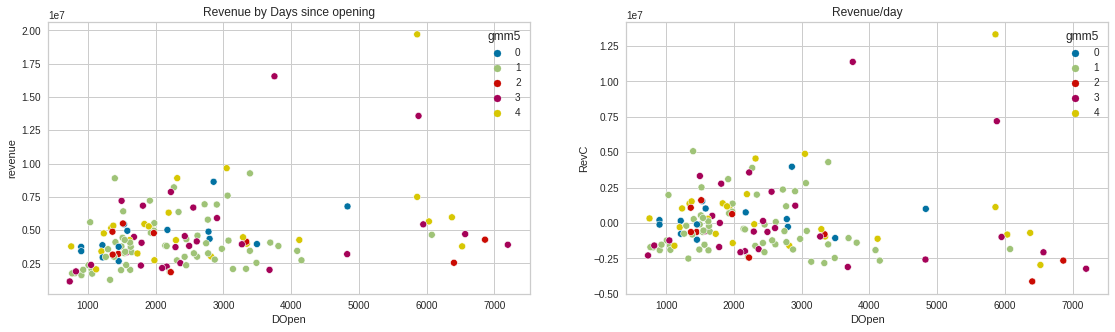

In [39]:
# Training Model
init = "kmeans"

model_gmm = GaussianMixture(n_components = 5, n_init = 1,init_params = init,random_state = 10).fit(df_training[cols_scale])
df_training["gmm5"] = pd.Categorical(model_gmm.predict(df_training[cols_scale]))

fig, ax = plt.subplots(1,2, figsize=(19,5) )
g1 = sns.scatterplot(data=df_training,x="DOpen",y="revenue", hue="gmm5", ax = ax[0]).set(title='Revenue by Days since opening');
g2 = sns.scatterplot(data=df_training,x="DOpen",y="RevC", hue="gmm5", ax = ax[1]).set(title='Revenue/day')
fig.show();

In [40]:
cluster_profile = df_training.groupby("gmm5").mean()

cluster_profile.style.highlight_max(color="lightgreen", axis=0)

## [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) dimensionality Reduction

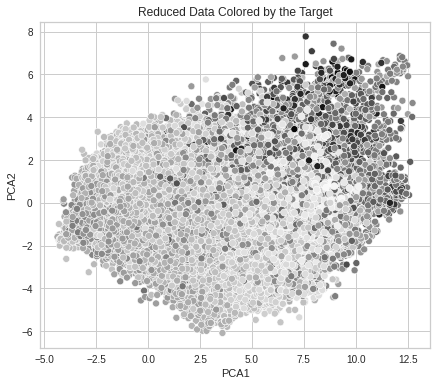

In [41]:
pca = PCA(n_components = 5).fit(df_merged[cols_scale])
reduced_data = pca.transform(df_merged[cols_scale])

plt.figure(figsize = (7,6))
sns.scatterplot(x = reduced_data[:, 0], y = reduced_data[:, 1], c = reduced_data[:, 2])
plt.title("Reduced Data Colored by the Target")
plt.xlabel("PCA1")
plt.ylabel("PCA2");

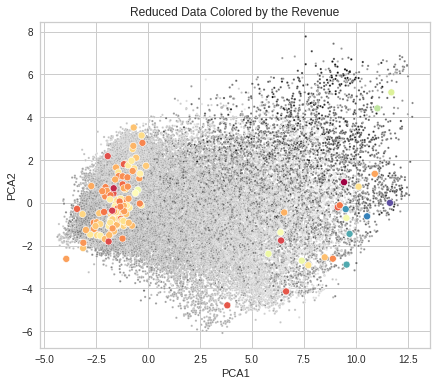

In [42]:
plt.figure(figsize = (7,6))
sns.scatterplot(x = reduced_data[:, 0], y = reduced_data[:, 1], c = reduced_data[:, 2],s=5)
sns.scatterplot(x = reduced_data[:, 0][df_merged['revenue'].notna()], y = reduced_data[:, 1][df_merged['revenue'].notna()], c = reduced_data[:, 3][df_merged['revenue'].notna()],cmap='Spectral')
plt.title("Reduced Data Colored by the Revenue")
plt.xlabel("PCA1")
plt.ylabel("PCA2");

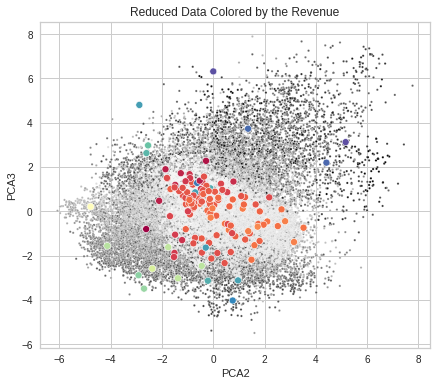

In [43]:
plt.figure(figsize = (7,6))
sns.scatterplot(x = reduced_data[:, 1], y = reduced_data[:, 2], c = reduced_data[:, 0],s=5)
sns.scatterplot(x = reduced_data[:, 1][df_merged['revenue'].notna()], y = reduced_data[:, 2][df_merged['revenue'].notna()], c = reduced_data[:, 0][df_merged['revenue'].notna()],cmap='Spectral')
plt.title("Reduced Data Colored by the Revenue")
plt.xlabel("PCA2")
plt.ylabel("PCA3");

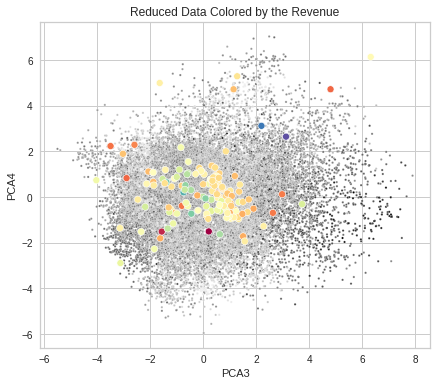

In [44]:
plt.figure(figsize = (7,6))
sns.scatterplot(x = reduced_data[:, 2], y = reduced_data[:, 3], c = reduced_data[:, 1],s=5)
sns.scatterplot(x = reduced_data[:, 2][df_merged['revenue'].notna()], y = reduced_data[:, 3][df_merged['revenue'].notna()], c = reduced_data[:, 1][df_merged['revenue'].notna()],cmap='Spectral')
plt.title("Reduced Data Colored by the Revenue")
plt.xlabel("PCA3")
plt.ylabel("PCA4");

#[3D Scatter Plot](https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d.html?highlight=scatter_3d#plotly.express.scatter_3d)

In [45]:
pca = PCA(n_components = 5 ).fit(df_merged[cols_scale])
temp = pca.transform(df_merged[cols_scale])
PCAfeatures = ["PCA1", "PCA2", "PCA3","PCA4","PCA5"]
pca_data = pd.DataFrame(temp, columns = PCAfeatures)

import plotly.express as px
fig = px.scatter_3d(pca_data, x = "PCA1", y = "PCA2", z = "PCA3", color ="PCA4")
fig.show()

In [46]:
pca_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100137 entries, 0 to 100136
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PCA1    100137 non-null  float64
 1   PCA2    100137 non-null  float64
 2   PCA3    100137 non-null  float64
 3   PCA4    100137 non-null  float64
 4   PCA5    100137 non-null  float64
dtypes: float64(5)
memory usage: 3.8 MB


Add PCA data to dataframe

In [51]:
df_PCAmerged = pd.concat([df_merged,pca_data], axis=1)

In [54]:
len(df_PCAmerged)

100137

In [55]:
df_trainPCA = df_PCAmerged[df_PCAmerged['revenue'].notna()]
df_testPCA = df_PCAmerged[df_PCAmerged['revenue'].isna()]

In [56]:
df_trainPCA.describe()

Id          P1          P2          P3          P4          P5  \
count  137.000000  137.000000  137.000000  137.000000  137.000000  137.000000   
mean    68.000000   -0.026068   -0.013506    0.121139   -0.022910    0.016598   
std     39.692569    1.034596    1.060133    1.225401    0.981339    1.135248   
min      0.000000   -1.097708   -2.398969   -5.003827   -1.347755   -0.928768   
25%     34.000000   -0.742224   -0.299557   -0.255760   -0.382309   -0.928768   
50%     68.000000   -0.386741    0.400247   -0.255760   -0.382309    0.009747   
75%    102.000000   -0.031257    0.400247    0.931256    0.583137    0.009747   
max    136.000000    2.812610    2.149757    3.898798    2.996751    5.640841   

               P6          P7          P8          P9  ...        DOpen  \
count  137.000000  137.000000  137.000000  137.000000  ...   137.000000   
mean     0.310026    0.056308    0.129157    0.113700  ...  2500.262774   
std      1.392654    1.054197    1.081386    1.077505  ...  1471.257507   
min     -1.228423   -1.973940   -2.287383   -0.735044  ...   730.000000   
25%     -0.575892   -0.138006   -0.541868   -0.735044  ...  1496.000000   
50%      0.076639   -0.138006    0.039970   -0.147782  ...  2162.000000   
75%      0.729170   -0.138006    0.039970   -0.147782  ...  2977.000000   
max      4.644355    2.156911    2.949161    2.788529  ...  7201.000000   

       City_Group       TypeC       revenue          RevC        PCA1  \
count  137.000000  137.000000  1.370000e+02  1.370000e+02  137.000000   
mean     0.569343    0.437956  4.453533e+06  6.797975e-12    0.176195   
std      0.496985    0.497956  2.576072e+06  2.435499e+06    3.982684   
min      0.000000    0.000000  1.149870e+06 -4.129899e+06   -3.945912   
25%      0.000000    0.000000  2.999068e+06 -1.535563e+06   -1.740294   
50%      1.000000    0.000000  3.939804e+06 -5.621522e+05   -1.329063   
75%      1.000000    1.000000  5.166635e+06  1.023154e+06   -0.698598   
max      1.000000    1.000000  1.969694e+07  1.332556e+07   11.709504   

             PCA2        PCA3        PCA4        PCA5  
count  137.000000  137.000000  137.000000  137.000000  
mean    -0.206562    0.079958    0.277531    0.003384  
std      1.486243    1.527096    1.373832    0.965487  
min     -4.786119   -4.029784   -2.899793   -2.671727  
25%     -1.016642   -0.843505   -0.591337   -0.533535  
50%     -0.396717    0.317966    0.184136   -0.060784  
75%      0.601568    0.909160    0.807960    0.620559  
max      5.166993    6.306630    6.138874    2.692142  

[8 rows x 48 columns]

## Kmean on PCA data

In [67]:
model_kmeans_1 = KMeans(n_clusters =7, random_state = 10).fit(df_trainPCA[PCAfeatures])
df_trainPCA["kmeanPCA"] = pd.Categorical(model_kmeans_1.labels_)
import plotly.express as px
fig = px.scatter_3d(df_trainPCA, x = "PCA1", y = "PCA2", z = "PCA3", color = "kmeanPCA")
fig.show();

# Test Regression Solutions

In [64]:
df_trainPCA.describe()

Id          P1          P2          P3          P4          P5  \
count  137.000000  137.000000  137.000000  137.000000  137.000000  137.000000   
mean    68.000000   -0.026068   -0.013506    0.121139   -0.022910    0.016598   
std     39.692569    1.034596    1.060133    1.225401    0.981339    1.135248   
min      0.000000   -1.097708   -2.398969   -5.003827   -1.347755   -0.928768   
25%     34.000000   -0.742224   -0.299557   -0.255760   -0.382309   -0.928768   
50%     68.000000   -0.386741    0.400247   -0.255760   -0.382309    0.009747   
75%    102.000000   -0.031257    0.400247    0.931256    0.583137    0.009747   
max    136.000000    2.812610    2.149757    3.898798    2.996751    5.640841   

               P6          P7          P8          P9  ...        DOpen  \
count  137.000000  137.000000  137.000000  137.000000  ...   137.000000   
mean     0.310026    0.056308    0.129157    0.113700  ...  2500.262774   
std      1.392654    1.054197    1.081386    1.077505  ...  1471.257507   
min     -1.228423   -1.973940   -2.287383   -0.735044  ...   730.000000   
25%     -0.575892   -0.138006   -0.541868   -0.735044  ...  1496.000000   
50%      0.076639   -0.138006    0.039970   -0.147782  ...  2162.000000   
75%      0.729170   -0.138006    0.039970   -0.147782  ...  2977.000000   
max      4.644355    2.156911    2.949161    2.788529  ...  7201.000000   

       City_Group       TypeC       revenue          RevC        PCA1  \
count  137.000000  137.000000  1.370000e+02  1.370000e+02  137.000000   
mean     0.569343    0.437956  4.453533e+06  6.797975e-12    0.176195   
std      0.496985    0.497956  2.576072e+06  2.435499e+06    3.982684   
min      0.000000    0.000000  1.149870e+06 -4.129899e+06   -3.945912   
25%      0.000000    0.000000  2.999068e+06 -1.535563e+06   -1.740294   
50%      1.000000    0.000000  3.939804e+06 -5.621522e+05   -1.329063   
75%      1.000000    1.000000  5.166635e+06  1.023154e+06   -0.698598   
max      1.000000    1.000000  1.969694e+07  1.332556e+07   11.709504   

             PCA2        PCA3        PCA4        PCA5  
count  137.000000  137.000000  137.000000  137.000000  
mean    -0.206562    0.079958    0.277531    0.003384  
std      1.486243    1.527096    1.373832    0.965487  
min     -4.786119   -4.029784   -2.899793   -2.671727  
25%     -1.016642   -0.843505   -0.591337   -0.533535  
50%     -0.396717    0.317966    0.184136   -0.060784  
75%      0.601568    0.909160    0.807960    0.620559  
max      5.166993    6.306630    6.138874    2.692142  

[8 rows x 48 columns]

In [65]:
PCAfeatures = ["PCA1","PCA2","PCA3"]
X = df_trainPCA[PCAfeatures]
y = df_trainPCA['revenue']  #choose are 'revenue', 'RevPday','RevPdayC'
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor,plot_importance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

regressors = [
    ('Linear Regression' , LinearRegression(fit_intercept=True)),
    ('RIDGE Regression' , RidgeCV(fit_intercept=True)),
    ('LASSO Regression' , LassoCV(fit_intercept=True)),
    ('Linear SVR',LinearSVR(fit_intercept=True)),
    ('Support Vector Machines' , SVR()),
    ('AdaBoost Regressor' , AdaBoostRegressor(n_estimators= 200, learning_rate= 0.04)),
    ('Random Forest' , RandomForestRegressor(n_estimators=200, max_depth= 5,oob_score=True,max_features=0.7)),
    ('K-nearest Neighbors' , KNeighborsRegressor(n_neighbors= 7)),
    ('SKlearn HistGBoost', HistGradientBoostingRegressor(max_iter=200,max_depth=5,learning_rate=0.04)),
    ('XGBoost' , XGBRegressor(n_estimators= 200, max_depth= 5, learning_rate= 0.04,max_features=0.7))]

results=pd.DataFrame(columns=['MAE','MSE','R2-score'])
for method,func in regressors:
  #print(func)
  model = func.fit(X_train, y_train)
  pred = model.predict(X_test)
  results.loc[method]= [mean_absolute_error(y_test,pred),
                          mean_squared_error(y_test,pred),
                          r2_score(y_test,pred)
                         ]
results

[21:59:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


MAE           MSE  R2-score
Linear Regression        2.011681e+06  1.243971e+13 -0.016819
RIDGE Regression         2.008483e+06  1.241076e+13 -0.014454
LASSO Regression         2.021699e+06  1.237787e+13 -0.011765
Linear SVR               4.755258e+06  3.484645e+13 -1.848343
Support Vector Machines  2.038286e+06  1.301545e+13 -0.063881
AdaBoost Regressor       2.080029e+06  1.227591e+13 -0.003431
Random Forest            2.092839e+06  1.221818e+13  0.001288
K-nearest Neighbors      1.964235e+06  1.112456e+13  0.090680
SKlearn HistGBoost       1.868380e+06  1.062114e+13  0.131829
XGBoost                  2.481773e+06  1.708755e+13 -0.396734